# **<center>Imports</center>**

In [1]:
#Network
from keras.layers import Conv2D, UpSampling2D, Input, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
from keras.layers import concatenate
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.optimizers import Adam, SGD, Adadelta, Lion, Nadam, Ftrl, AdamW
from keras.models import Model
import tensorflow as tf
import pandas as pd
import numpy as np

#Images
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage.io import imsave
import cv2

#Utilities
from sklearn.model_selection import train_test_split
from cutecharts.charts import Line
from urllib.request import urlopen
import requests
import warnings
import io
import os

warnings.filterwarnings("ignore")

# **<center>Data Collection</center>**

In [276]:
train_data_path = "data"
test_data_path = "photos/test/"
val_data_path = "photos/val/"

In [253]:
data_path = "pokemon1/images/images/"

In [136]:
train_gen = ImageDataGenerator(rescale=1./255)
train = train_gen.flow_from_directory(train_data_path, target_size=(256,256), batch_size=50, class_mode=None)

Found 2426 images belonging to 1 classes.


In [137]:
test_gen = ImageDataGenerator(rescale=1./255)
test = test_gen.flow_from_directory(test_data_path, target_size=(256, 256), batch_size=50, class_mode=None)

Found 2426 images belonging to 1 classes.


In [138]:
val_gen = ImageDataGenerator(rescale=1./255)
val = val_gen.flow_from_directory(val_data_path, target_size=(256, 256), batch_size=50, class_mode=None)

Found 168 images belonging to 1 classes.


In [254]:
def prepareInputData(path, h, w):
    X=[]
    y=[]
    for imageDir in os.listdir(path):
        try:
            img = cv2.imread(path + imageDir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
            img = img.astype(np.float32)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            # resize the lightness channel to network input size 
            img_lab_rs = cv2.resize(img_lab, (w, h)) # resize image to network input size
            img_l = img_lab_rs[:,:,0] # pull out L channel
            img_ab = img_lab_rs[:,:,1:]#Extracting the ab channel
            img_ab = img_ab/128
            #The true color values range between -128 and 128. This is the default interval 
            #in the Lab color space. By dividing them by 128, they too fall within the -1 to 1 interval.
            X.append(img_l)
            y.append(img_ab)
        except:
            pass
    X = np.array(X)
    y = np.array(y)
    
    return X,y

In [277]:
X1_train,y1_train = prepareInputData(train_data_path + "train_data/", 256, 256)
X1_test, y1_test = prepareInputData(test_data_path + "test_data/", 256, 256)
#X_val, y_val = prepareInputData(val_data_path + "val_data/", 256, 256)

Premature end of JPEG file
Premature end of JPEG file


In [298]:
X, y = prepareInputData("data/", 256, 256)

In [299]:
X_train = X[:int(len(X)*0.8)]
X_test = X[int(len(X)*0.8):]
y_train = y[:int(len(y)*0.8)]
y_test = y[:int(len(y)*0.8)]

In [257]:
len(X_train)

647

In [258]:
len(X_test)

162

In [170]:
X_train[0]

array([[100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       ...,
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.]], dtype=float32)

In [259]:
np.unique(y_train[6])

array([0.], dtype=float32)

# **<center>Making the Model</center>**

In [550]:
def createModel(networkInput):
    my_model = Conv2D(16,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)
 #   my_model = MaxPooling2D(pool_size=(2,2),padding='same')(my_model)

    #128, 128, 16 with max pooling
    #256, 256, 16 with max pooling


    my_model = Conv2D(32,(3,3),padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)
#    my_model = MaxPooling2D(pool_size=(2,2),padding='same')(my_model)

    print(my_model)
    print(networkInput)

    #256, 256, 32 without both, 128, 128, 32 with just first one
    #64, 64, 32 with both, 128, 128, 32 with just second one. 

    
#    my_model = Conv2D(64,(3,3),padding='same',strides=1)(my_model)
#    my_model = LeakyReLU()(my_model)
#    my_model = BatchNormalization()(my_model)
#    my_model = MaxPooling2D(pool_size=(2,2),padding='same')(my_model)
    
#    my_model = Conv2D(128,(3,3),padding='same',strides=1)(my_model)
#    my_model = LeakyReLU()(my_model)
#    my_model = BatchNormalization()(my_model)
    
#    my_model = Conv2D(256,(3,3),padding='same',strides=1)(my_model)
#    my_model = LeakyReLU()(my_model)
#    my_model = BatchNormalization()(my_model)

    #32, 32, 256
    
#    my_model = UpSampling2D((2, 2))(my_model)

    #64, 64, 256

    my_model = Conv2D(128,(3,3),padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    #64, 64, 128
    
  #  my_model = UpSampling2D((2, 2))(my_model)
    my_model = Conv2D(64,(3,3), padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    #128, 128, 64

#    my_model = UpSampling2D((2, 2))(my_model)
    my_model = Conv2D(32,(3,3), padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    print(my_model)
    print(networkInput)
    
    concat_ = concatenate([my_model, networkInput]) 
    
    my_model = Conv2D(64,(3,3), padding='same',strides=1)(concat_)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)
    
    my_model = Conv2D(32,(3,3),padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)
    
    my_model = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(my_model)

    return my_model


In [229]:
def createModelTwo(networkInput):
    my_model = Conv2D(16,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(32,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(64,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(128,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(256,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(512,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

#    my_model = MaxPooling2D(pool_size=(2,2),padding='same')(my_model)

#    my_model = Conv2D(512,(3,3),padding='same',strides=1)(networkInput)
 #   my_model = LeakyReLU()(my_model)
  #  my_model = BatchNormalization()(my_model)

    my_model = Conv2D(256,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(128,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(64,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(32,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(16,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(64,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)


    my_model = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(my_model)

    return my_model


In [290]:
networkInput = Input(shape=(256, 256,1))
networkOutput = createModelTwo(networkInput)
model = Model(inputs=networkInput, outputs=networkOutput)

In [81]:
def custom_loss(y_true, y_pred):
    # Split the predicted and ground truth tensors into a and b channels
    a_true, b_true = tf.split(y_true, num_or_size_splits=2, axis=-1)
    a_pred, b_pred = tf.split(y_pred, num_or_size_splits=2, axis=-1)
    
    # Compute the Euclidean distance between a and b channels 4
    color_loss = tf.sqrt(tf.square(a_true - a_pred) + tf.square(b_true - b_pred))
    
    # Compute hue and saturation from a and b channels of predicted image
    hue_true = tf.math.atan2(b_true, a_true) #-pi to pi
    saturation_true = tf.sqrt(tf.square(a_true) + tf.square(b_true)) 
    hue_pred = tf.math.atan2(b_pred, a_pred)
    saturation_pred = tf.sqrt(tf.square(a_pred) + tf.square(b_pred))
    
    # Define the weighting factor for emphasizing saturation over hue
    saturation_weight = 3.0
    
    # Compute the weighted hue-saturation loss
    hue_saturation_loss = tf.square(hue_pred - hue_true) + saturation_weight * tf.square(saturation_pred - saturation_true)
    
    # Combine the color loss and hue-saturation loss
    total_loss = tf.add(color_loss,hue_saturation_loss)
    
    # Return the mean loss over the batch
    return tf.reduce_mean(tf.sqrt(hue_saturation_loss))


In [231]:
def hue_bin_loss(y_true, y_pred):
    a_true, b_true = tf.split(y_true, num_or_size_splits=2, axis=-1)
    a_pred, b_pred = tf.split(y_pred, num_or_size_splits=2, axis=-1)

    condition1 = tf.logical_and(tf.less(y_true, 0), tf.less(y_pred, 0))
    condition2 = tf.logical_and(tf.greater(y_true, 0), tf.greater(y_pred, 0))

    hl = tf.where(condition1 | condition2, 0.0, tf.abs(y_pred - y_true))

    saturation_true = tf.sqrt(tf.square(a_true) + tf.square(b_true))
    saturation_pred = tf.sqrt(tf.square(a_pred) + tf.square(b_pred))
    sl = tf.abs(saturation_true - saturation_pred)

    color_loss = tf.sqrt(tf.square(a_true - a_pred) + tf.square(b_true - b_pred))
    total_loss = tf.add(color_loss, (0.75*hl + sl))

    return tf.reduce_mean(0.5*hl + sl)  # Use reduce_mean to ensure a scalar loss value


In [282]:
def custom_hue_loss(y_true, y_pred):
    condition1 = tf.logical_and(tf.less(y_true, 0), tf.less(y_pred, 0))
    condition2 = tf.logical_and(tf.greater(y_true, 0), tf.greater(y_pred, 0))

    hl = tf.where(condition1 | condition2, 0.0, 0.1 * tf.abs(y_pred - y_true))

    return hl


In [23]:
from kaggle.api.kaggle_api_extended import KaggleApi


In [206]:
def downloadRawData():
    """
    Obtains data from Kaggle using the API. Only run once (or if you need to
    redownload for some reason).
    """
    api = KaggleApi()
    api.authenticate()

    dataset_name = "vishalsubbiah/pokemon-images-and-types"

    if not os.path.exists("pokemon"):
        os.mkdir("pokemon")

    api.dataset_download_files(dataset_name , path="pokemon1", unzip=True)

In [207]:
downloadRawData()

In [76]:
IMG_SIZE = (256, 256)

In [210]:
def setup_generator(subset, datagen):
    return datagen.flow_from_directory(
        "pokemon1/images/",
        target_size=IMG_SIZE,
        batch_size=32,
        class_mode=None,  # Set to 'input' for X, 'none' for Y
        subset=subset
    )


def preprocessBatch(batch):
    """Preprocesses a batch of images for colorization, handling single images and batches.

    Args:
        batch: A NumPy array of images with shape (batch_size, height, width, channels)
            or a single image with shape (height, width, channels).

    Returns:
        A tuple of preprocessed X and Y data, both as NumPy arrays with shapes
        (batch_size, height, width, channels).
    """
    if len(batch) != 32:  # Single image
        print(f"batch size: {len(batch)}")
        try:
            img = cv2.cvtColor(batch, cv2.COLOR_BGR2RGB)

            # Reassess necessity of grayscale conversion
            # img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            # img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

            img = img.astype(np.float32)
            img = cv2.resize(img, (256, 256))
            img = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)

            X_batch = img[:, :, 0:1][np.newaxis, ...]  # Add a batch dimension
            Y_batch = img[:, :, 1:][np.newaxis, ...]  # Add a batch dimension

        except:
            print("something happend")

    else:  # Batch of images
        X_batch = np.empty((batch.shape[0], IMG_SIZE[0], IMG_SIZE[1], 1), dtype=np.float32)
        Y_batch = np.empty((batch.shape[0], IMG_SIZE[0], IMG_SIZE[1], 2), dtype=np.float32)

        for i, input_img in enumerate(batch):
            try:
                img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)

                # Reassess necessity of grayscale conversion
                # img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                # img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

                img = img.astype(np.float32)
                img = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)

                X_batch[i] = img[:, :, 0:1]
                Y_batch[i] = img[:, :, 1:]

            except Exception as e:
                print(f"An issue occurred trying to preprocess image {i + 1}:\n{e}")

    #print(f"After preprocessing, X_batch has the following shape: {X_batch.shape}")
    #print(f"After preprocessing, Y_batch has the following shape: {Y_batch.shape}")

    return X_batch, Y_batch

In [211]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2, preprocessing_function=preprocessBatch)
train_generator = setup_generator(datagen=datagen, subset='training')
test_generator = setup_generator(datagen=datagen, subset='validation')


Found 648 images belonging to 1 classes.
Found 161 images belonging to 1 classes.


In [212]:
def train(x_train, y_train, batchSize : int, epochs : int, callBacks = [], lr: float = 0.001) -> None :
    optimizer = Adam(lr)

    losses = []
    print("train shape: ", x_train.shape)
    num_steps = x_train.shape[0]//batchSize

    print(f"Epochs {epochs}, steps per epoch {num_steps}")

    for epoch in range(epochs):
        for step in range(num_steps):
            start_idx = batchSize * step
            end_idx = batchSize * (step + 1)
            indices = np.arange(len(x_train))
            np.random.shuffle(indices)
            selected_indices = indices[start_idx:end_idx]
            X_batch = x_train[selected_indices]
            y_batch = y_train[selected_indices]


            with tf.GradientTape() as tape:
                colorized = model(X_batch)
                
                hue_loss = hue_bin_loss(y_batch, colorized)
                losses.append(hue_loss.numpy())                    
                                    
                grads = tape.gradient(hue_loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        print(f"epoch {epoch}/{epochs} ::: loss {tf.math.reduce_mean(losses)}")

            # for func in callBacks:
            #     func()
    
    print(f"Model finished training......")

In [213]:
def train_with_generator(epochs: int, lr: float = 0.001) -> None:
    optimizer = Adam(lr)

    num_steps = len(train_generator) - 1
    losses = []

    print(f"Epochs {epochs}, steps per epoch {num_steps}")

    for epoch in range(epochs):
        for step in range(num_steps):
            X_batch, y_batch = preprocessBatch(next(train_generator))

            with tf.GradientTape() as tape:
                colorized = model(X_batch)
                hue_loss = hue_bin_loss(y_batch, colorized)
                losses.append(hue_loss.numpy())

                grads = tape.gradient(hue_loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))

        print(f"epoch {epoch}/{epochs} ::: loss {tf.math.reduce_mean(losses)}")
    
    print("Model finished training!")

In [214]:
train_with_generator(epochs=50, lr=0.001)

Epochs 50, steps per epoch 20
batch size: 256


TypeError: can't multiply sequence by non-int of type 'float'

In [215]:
train(X_train, y_train, batchSize=32, epochs=50, lr=0.005)

train shape:  (640, 256, 256)
Epochs 50, steps per epoch 20
epoch 0/50 ::: loss 1.8263839483261108
epoch 1/50 ::: loss 1.8181393146514893
epoch 2/50 ::: loss 1.8141134977340698
epoch 3/50 ::: loss 1.8184022903442383
epoch 4/50 ::: loss 1.8189277648925781
epoch 5/50 ::: loss 1.818647861480713
epoch 6/50 ::: loss 1.8190363645553589
epoch 7/50 ::: loss 1.8185080289840698
epoch 8/50 ::: loss 1.8187878131866455
epoch 9/50 ::: loss 1.819294810295105
epoch 10/50 ::: loss 1.8194687366485596
epoch 11/50 ::: loss 1.8190429210662842
epoch 12/50 ::: loss 1.8184101581573486
epoch 13/50 ::: loss 1.8176136016845703
epoch 14/50 ::: loss 1.8175675868988037
epoch 15/50 ::: loss 1.8171722888946533
epoch 16/50 ::: loss 1.8170392513275146
epoch 17/50 ::: loss 1.8166093826293945
epoch 18/50 ::: loss 1.8162695169448853
epoch 19/50 ::: loss 1.8163089752197266
epoch 20/50 ::: loss 1.816368818283081
epoch 21/50 ::: loss 1.8165866136550903
epoch 22/50 ::: loss 1.8166590929031372
epoch 23/50 ::: loss 1.8172935247

In [291]:
LEARNING_RATE = 0.001
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                            loss=hue_bin_loss)
model.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_297 (Conv2D)         (None, 256, 256, 64)      640       
                                                                 
 leaky_re_lu_275 (LeakyReLU  (None, 256, 256, 64)      0         
 )                                                               
                                                                 
 batch_normalization_275 (B  (None, 256, 256, 64)      256       
 atchNormalization)                                              
                                                                 
 conv2d_298 (Conv2D)         (None, 256, 256, 2)       1154      
                                                                 
Total params: 2050 (8.01 KB)
Trainable params: 1922 (7.51 

In [304]:
NUM_EPOCHS = 150
NUM_STEPS = round(len(X_train)/NUM_EPOCHS)-1
VAL_STEPS = round(len(X_test)//NUM_EPOCHS)-1

In [303]:
len(X_train)/150

23.026666666666667

In [306]:
NUM_STEPS

22

In [307]:
def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,256,256,1)
        y_input = y_[i].reshape(1,256,256,2)
        yield (X_input,y_input)

history = model.fit(GenerateInputs(X_train,y_train),epochs=NUM_EPOCHS,verbose=1, steps_per_epoch=NUM_STEPS, shuffle=True,validation_data=GenerateInputs(X_test, y_test), validation_steps=VAL_STEPS)

Epoch 1/150
22/22 [==============================] - 0s 14ms/step - loss: 0.0990 - val_loss: 0.9192
Epoch 2/150
22/22 [==============================] - 0s 14ms/step - loss: 0.1069 - val_loss: 1.6981
Epoch 3/150
22/22 [==============================] - 0s 14ms/step - loss: 0.0812 - val_loss: 1.4684
Epoch 4/150
22/22 [==============================] - 0s 14ms/step - loss: 0.0535 - val_loss: 1.3419
Epoch 5/150
22/22 [==============================] - 0s 13ms/step - loss: 0.0545 - val_loss: 0.9117
Epoch 6/150
22/22 [==============================] - 0s 13ms/step - loss: 0.1127 - val_loss: 0.9981
Epoch 7/150
22/22 [==============================] - 0s 13ms/step - loss: 0.0660 - val_loss: 1.4533
Epoch 8/150
22/22 [==============================] - 0s 14ms/step - loss: 0.0515 - val_loss: 1.3938
Epoch 9/150
22/22 [==============================] - 0s 13ms/step - loss: 0.0894 - val_loss: 0.5204
Epoch 10/150
22/22 [==============================] - 0s 14ms/step - loss: 0.0518 - val_loss: 0.8186

2024-01-05 15:15:00.448876: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 5743684660120303807
2024-01-05 15:15:00.448890: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 6276639929041978693
2024-01-05 15:15:00.448899: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9995856745810218078


22/22 [==============================] - 0s 14ms/step - loss: 0.0161
Epoch 146/150
22/22 [==============================] - 0s 13ms/step - loss: 0.0109
Epoch 147/150
22/22 [==============================] - 0s 13ms/step - loss: 0.0658
Epoch 148/150
22/22 [==============================] - 0s 13ms/step - loss: 0.0668
Epoch 149/150
22/22 [==============================] - 0s 13ms/step - loss: 0.0647
Epoch 150/150
22/22 [==============================] - 0s 13ms/step - loss: 0.0148


In [658]:
data = {
 #   "acc": list(history.history["acc"]),
#    "val_acc": list(history.history["val_acc"]),
    "loss": list(history.history["loss"]),
    "val_loss": list(history.history["val_loss"])
}

In [299]:
chart = Line("Model Results")
chart.set_options(
    labels=list(range(50)),
    x_label="Epoch",
    y_label="Percent",
)


#chart.add_series("acc", data["acc"])
#chart.add_series("val_acc", data["val_acc"])
chart.add_series("loss", data["loss"])
chart.add_series("val_loss", data["val_loss"])
#chart.render_notebook()
chart.render_notebook()

# **<center>Testing the Model</center>**

In [308]:
def ExtractTestInput(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#    img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    img_=img.astype(np.float32)
    img_lab_rs = cv2.resize(img_, (256, 256)) # resize image to network input size
    img_l = img_lab_rs[:,:,0] # pull out L channel
    img_l_reshaped = img_l.reshape(1,256,256,1)
    
    return img_l_reshaped

1/1 [==============================] - 0s 10ms/step
(1, 256, 256, 1)
(1, 256, 256, 2)


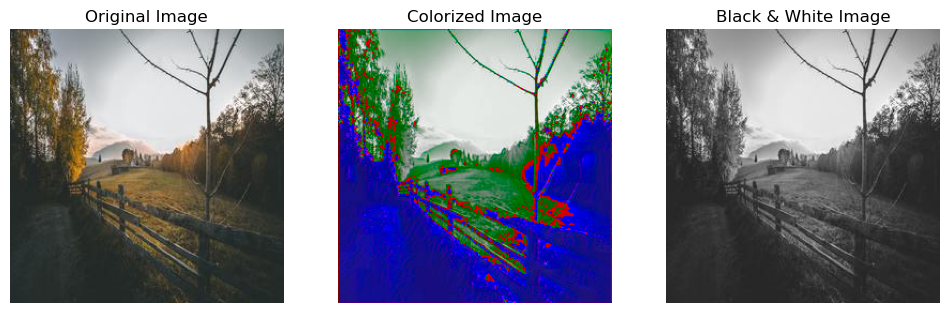

In [316]:
# Load a sample test image
TestImagePath = "photos/val/val_data/zl50uXt9dbs.jpg"
img = cv2.imread(TestImagePath)

# Extract test input
image_for_test = ExtractTestInput(img)

# Make a prediction using the trained model
Prediction = model.predict(image_for_test)
Prediction = Prediction * 128
Prediction = Prediction.reshape(256, 256, 2)
#loss = image_for_test[:,:,1:]-Prediction
print(image_for_test.shape)

# Create Lab image with L channel from original image and predicted a,b channels
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
img_lab_colorized = img_lab.copy()
img_lab_colorized[:, :, 1:] = Prediction

newImg = np.array(image_for_test + Prediction)
#newImg = newImg.reshape(256,256,3)
print(newImg.shape)

# Convert Lab image to RGB
img_colorized = cv2.cvtColor(img_lab_colorized, cv2.COLOR_Lab2RGB)

# Display the images
plt.figure(figsize=(12, 6))

plt.title("Image Test")

# Original Image
plt.subplot(1, 3, 1)
img_original = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_original)
plt.title("Original Image")
plt.axis('off')

# Colorized Image
plt.subplot(1, 3, 2)
plt.imshow(img_colorized)
plt.title("Colorized Image")
plt.axis('off')

# Ground Truth Image
plt.subplot(1, 3, 3)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)
plt.imshow(img_gray)
plt.title("Black & White Image")
plt.axis('off')

plt.show()


In [1004]:
len(np.unique(Prediction[:,:,0]))

62920

1/1 [==============================] - 0s 11ms/step
(1, 256, 256, 1)
(1, 256, 256, 2)


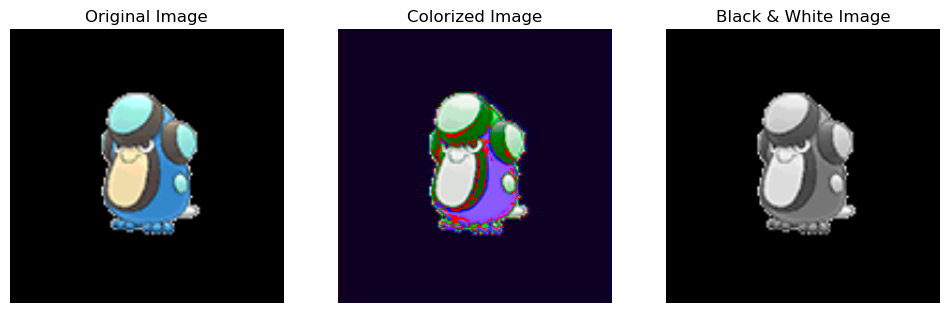

In [321]:
# Load a sample test image
TestImagePath = "pokemon1/images/images/palpitoad.png"
img = cv2.imread(TestImagePath)
img = cv2.resize(img, (256, 256))

# Extract test input
image_for_test = ExtractTestInput(img)

# Make a prediction using the trained model
Prediction = model.predict(image_for_test)
Prediction = Prediction * 128
Prediction = Prediction.reshape(256, 256, 2)
#loss = image_for_test[:,:,1:]-Prediction
print(image_for_test.shape)

# Create Lab image with L channel from original image and predicted a,b channels
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
img_lab_colorized = img_lab.copy()
img_lab_colorized[:, :, 1:] = Prediction

newImg = np.array(image_for_test + Prediction)
#newImg = newImg.reshape(256,256,3)
print(newImg.shape)

# Convert Lab image to RGB
img_colorized = cv2.cvtColor(img_lab_colorized, cv2.COLOR_Lab2RGB)

# Display the images
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 3, 1)
img_original = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_original)
plt.title("Original Image")
plt.axis('off')

# Colorized Image
plt.subplot(1, 3, 2)
plt.imshow(img_colorized)
plt.title("Colorized Image")
plt.axis('off')

# Ground Truth Image
plt.subplot(1, 3, 3)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)
plt.imshow(img_gray)
plt.title("Black & White Image")
plt.axis('off')

plt.show()


In [652]:
#model.save(filepath="triple_trained")

INFO:tensorflow:Assets written to: triple_trained/assets


INFO:tensorflow:Assets written to: triple_trained/assets


In [242]:
len(np.unique(Prediction))

62964

In [118]:
from keras.saving import load_model

In [948]:
model.save(filepath="trial.h5")

In [119]:
model1 = load_model("trial.h5", custom_objects={"hue_bin_loss": hue_bin_loss})

In [21]:
# Load a sample test image
TestImagePath = "data/00000075_(4).jpg"
img = cv2.imread(TestImagePath)
img = cv2.resize(img, (256, 256))

# Extract test input
image_for_test = ExtractTestInput(img)

# Make a prediction using the trained model
Prediction = model1.predict(image_for_test)
Prediction = Prediction * 128
Prediction = Prediction.reshape(256, 256, 2)
#loss = image_for_test[:,:,1:]-Prediction
print(image_for_test.shape)

# Create Lab image with L channel from original image and predicted a,b channels
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
img_lab_colorized = img_lab.copy()
img_lab_colorized[:, :, 1:] = Prediction

newImg = np.array(image_for_test + Prediction)
#newImg = newImg.reshape(256,256,3)
print(newImg.shape)

# Convert Lab image to RGB
img_colorized = cv2.cvtColor(img_lab_colorized, cv2.COLOR_Lab2RGB)

# Display the images
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 3, 1)
img_original = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_original)
plt.title("Original Image")
plt.axis('off')

# Colorized Image
plt.subplot(1, 3, 2)
plt.imshow(img_colorized)
plt.title("Colorized Image")
plt.axis('off')

# Ground Truth Image
plt.subplot(1, 3, 3)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)
plt.imshow(img_gray)
plt.title("Black & White Image")
plt.axis('off')

plt.show()


NameError: name 'model1' is not defined

In [134]:
model1.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                            loss="mse")


In [135]:
model1.fit(GenerateInputs(X_train,y_train),epochs=NUM_EPOCHS,verbose=1, steps_per_epoch=NUM_STEPS, shuffle=True,validation_data=GenerateInputs(X_test, y_test), validation_steps=VAL_STEPS-2)

Epoch 1/50
 5/69 [=>............................] - ETA: 0s - loss: 1.2360e-04 

2024-01-01 10:44:29.985665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


69/69 [==============================] - 1s 12ms/step - loss: 7.4427e-05 - val_loss: 3.7675e-05
Epoch 2/50
 6/69 [=>............................] - ETA: 0s - loss: 9.2010e-06

2024-01-01 10:44:30.848777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


69/69 [==============================] - 1s 11ms/step - loss: 2.6484e-05 - val_loss: 9.3436e-05
Epoch 3/50
69/69 [==============================] - 1s 10ms/step - loss: 3.3572e-05 - val_loss: 1.3932e-05
Epoch 4/50
69/69 [==============================] - 1s 10ms/step - loss: 8.1420e-06 - val_loss: 1.1770e-04
Epoch 5/50
69/69 [==============================] - 1s 10ms/step - loss: 9.4756e-06 - val_loss: 1.5648e-05
Epoch 6/50
69/69 [==============================] - 1s 10ms/step - loss: 5.9782e-06 - val_loss: 1.9761e-05
Epoch 7/50
69/69 [==============================] - 1s 11ms/step - loss: 2.5960e-05 - val_loss: 6.3629e-05
Epoch 8/50
69/69 [==============================] - 1s 11ms/step - loss: 4.2260e-06 - val_loss: 7.0238e-05
Epoch 9/50
69/69 [==============================] - 1s 11ms/step - loss: 1.3416e-04 - val_loss: 9.0082e-05
Epoch 10/50
69/69 [==============================] - 1s 11ms/step - loss: 6.6331e-06 - val_loss: 3.0434e-05
Epoch 11/50
69/69 [============================